In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylift import TransformedOutcome
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import t
plt.style.use('fivethirtyeight')

c:\users\wongt\desktop\projects\uplift_modelling\um_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df = pd.read_csv("data/hillstrom/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
df.visit.value_counts()

0    54606
1     9394
Name: visit, dtype: int64

In [3]:
df.conversion.value_counts()

0    63422
1      578
Name: conversion, dtype: int64

Only 578 customers made purchases, a rather low conversion rate

<br>
<br>

**References**

- [Stochastic solutions MineThatData Email Analytics Challenge (2008)](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf)
- [Athey and Imbens (2015)](https://pdfs.semanticscholar.org/86ce/004214845a1683d59b64c4363a067d342cac.pdf)
- [Pylift blog post (2018)](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling/)
- [Ascarza (2018)](https://journals.sagepub.com/doi/full/10.1509/jmr.16.0163)
- [Gutierrez and Gerardy (2017)](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)
- [Kunzel et al (2019)](https://arxiv.org/pdf/1706.03461.pdf)
- [Rzepakowski and Jaroszewicz (2012)](https://pdfs.semanticscholar.org/e979/ba084f34345b2ac8783df2b4a3295ae9273f.pdf)

<br>
<br>

### Population average treatment effects of the E-Mail campaign

$$\tau^{p} = \mathbb E[Y(1) - Y(0)]$$

**On visits**

In [3]:
mens = df[df.segment=="Mens E-Mail"].visit.mean()*100
womens = df[df.segment=="Womens E-Mail"].visit.mean()*100
control = df[df.segment=="No E-Mail"].visit.mean()*100
print("Men's E-Mail visit rate: {:.2f}%".format(mens))
print("Women's E-Mail visit rate: {:.2f}%".format(womens))
print("Control E-mail visit Rate: {:.2f}%".format(control))
print("---------------------------------")
print("Men's visit rate uplift: {:.2f}%".format(mens-control))
print("Womens's visit rate uplift: {:.2f}%".format(womens-control))

Men's E-Mail visit rate: 18.28%
Women's E-Mail visit rate: 15.14%
Control E-mail visit Rate: 10.62%
---------------------------------
Men's visit rate uplift: 7.66%
Womens's visit rate uplift: 4.52%


**On conversion**

In [12]:
mens = df[df.segment=="Mens E-Mail"].conversion.mean()*100
womens = df[df.segment=="Womens E-Mail"].conversion.mean()*100
control = df[df.segment=="No E-Mail"].conversion.mean()*100
print("Men's E-Mail conversion rate: {:.2f}%".format(mens))
print("Women's E-Mail conversion rate: {:.2f}%".format(womens))
print("Control E-mail conversion Rate: {:.2f}%".format(control))
print("---------------------------------")
print("Men's conversion rate uplift: {:.2f}%".format(mens-control))
print("Womens's conversion rate uplift: {:.2f}%".format(womens-control))

Men's E-Mail conversion rate: 1.25%
Women's E-Mail conversion rate: 0.88%
Control E-mail conversion Rate: 0.57%
---------------------------------
Men's conversion rate uplift: 0.68%
Womens's conversion rate uplift: 0.31%


**On spending**

In [14]:
mens = df[df.segment=="Mens E-Mail"].spend.mean()
womens = df[df.segment=="Womens E-Mail"].spend.mean()
control = df[df.segment=="No E-Mail"].spend.mean()
print("Men's E-Mail spending: ${:.2f}".format(mens))
print("Women's E-Mail spending: ${:.2f}".format(womens))
print("Control E-mail spending: ${:.2f}".format(control))
print("---------------------------------")
print("Men's spending uplift: ${:.2f}".format(mens-control))
print("Womens's spending uplift: ${:.2f}".format(womens-control))

Men's E-Mail spending: $1.42
Women's E-Mail spending: $1.08
Control E-mail spending: $0.65
---------------------------------
Men's spending uplift: $0.77
Womens's spending uplift: $0.42


<br>
<br>

### Formulation

$$\mathbb E[\text{spend}] = \mathbb E[\text{spend|purchase}] \times \text{P}(\text{purchase|visit}) \times \text{P}(\text{visit})$$


In [521]:
print("Mens average spend given purchase: ${:.2f}".format(df[(df.conversion==1) & (df.segment=='Mens E-Mail')].spend.mean()))
print("Womens average spend given purchase: ${:.2f}".format(df[(df.conversion==1) & (df.segment=='Womens E-Mail')].spend.mean()))
print("Control average spend given purchase: ${:.2f}".format(df[(df.conversion==1) & (df.segment=='No E-Mail')].spend.mean()))

Mens average spend given purchase: $113.53
Womens average spend given purchase: $121.89
Control average spend given purchase: $114.00


In [522]:
print("Mens purchase rate given visit: {:.2f}%".format(100*(len(df[(df.conversion==1) & (df.segment=='Mens E-Mail')]) / len(df[(df.visit==1) & (df.segment=='Mens E-Mail')]))))
print("Womens purchase rate given visit: {:.2f}%".format(100*(len(df[(df.conversion==1) & (df.segment=='Womens E-Mail')]) / len(df[(df.visit==1) & (df.segment=='Womens E-Mail')]))))
print("Control purchase rate given visit: {:.2f}%".format(100*(len(df[(df.conversion==1) & (df.segment=='No E-Mail')]) / len(df[(df.visit==1) & (df.segment=='No E-Mail')]))))

Mens purchase rate given visit: 6.86%
Womens purchase rate given visit: 5.84%
Control purchase rate given visit: 5.39%


In [523]:
print("Mens visit rate: {:.2f}%".format(100*(len(df[(df.visit==1) & (df.segment=='Mens E-Mail')]) / len(df[(df.segment=='Mens E-Mail')]))))
print("Womens visit rate: {:.2f}%".format(100*(len(df[(df.visit==1) & (df.segment=='Womens E-Mail')]) / len(df[(df.segment=='Womens E-Mail')]))))
print("Control visit rate: {:.2f}%".format(100*(len(df[(df.visit==1) & (df.segment=='No E-Mail')]) / len(df[(df.segment=='No E-Mail')]))))

Mens visit rate: 18.28%
Womens visit rate: 15.14%
Control visit rate: 10.62%


Multiplying the corresponding quantities above gives:

In [42]:
print("Mens mean spend: ${:.2f}".format(df[(df.segment=='Mens E-Mail')].spend.mean()))
print("Womens mean spend: ${:.2f}".format(df[(df.segment=='Womens E-Mail')].spend.mean()))
print("Control mean spend: ${:.2f}".format(df[(df.segment=='No E-Mail')].spend.mean()))

Mens mean spend: $1.42
Womens mean spend: $1.08
Control mean spend: $0.65


aka spend per head

<br>
<br>

### Build Uplift & Response models for Women's Visit Rate

**Why only model uplift for visit rate?**

Due to the low marginal conversion rates, the stability of the uplift on Purchase (conversion) and Spending (spend) is not robust when using 10% samples of the data. After splitting the data in half for calibration/validation and producing 10% deciles, the variance of the uplift for conversion and spend has high variance, is likely not significantly different from 0, and is thus not suitable for uplift modelling. 

Also, from the formulation above, it can be seen that the increase in mean spending due to the E-Mails (compared to the control group) for both Women and particularly Men is dominated by an increase in visit rate. Hence it is an obvious candidate for uplift modelling; which customers will have the largest gain in visit probability and hence spending due to receiving the E-Mail?.

See Section 4 and section 5.2 of [Stochastic Solutions (2008)](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf) for more details

In [3]:
mens_df = df[df.segment!='Womens E-Mail'].copy()
womens_df = df[df.segment!='Mens E-Mail'].copy()

# Label encode segment as treatment column
mens_df.segment.replace({'Mens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)

# Drop conversion and spend outcomes
mens_df.drop(columns=['conversion', 'spend'], inplace=True)
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

# Ordinal encode "history_segment"
hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

mens_df.history_segment.replace(hist_seg_map, inplace=True)
womens_df.history_segment.replace(hist_seg_map, inplace=True)

# OHE categorical variables
mens_df = pd.get_dummies(mens_df)
womens_df = pd.get_dummies(womens_df)

# Label treatment and outcome columns
mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)

state = 7

# Build Uplift model using pylift package
up1 = TransformedOutcome(womens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=womens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

In [ ]:
# RandomizedSearchCV.
up1.randomized_search(param_distributions={'max_depth': range(3,120),
                                           'min_samples_split': range(500,2000),
                                           'max_features':['auto', 'sqrt'],
                                           'n_estimators': range(3,200),
                                           'random_state': [state]
                                          },
                      n_iter=400,
                      cv=5,
                      n_jobs=6,
                      random_state=state
                     )

up1.rand_search_.best_params_

In [4]:
best_params = {'random_state': 7,
 'n_estimators': 40,
 'min_samples_split': 4800,
 'max_features': 'sqrt',
 'max_depth': 9}

up1.fit(**best_params)

**Evaluate uplift model**

Cumulative Gain AUC: 0.00997
Cumulative Gain AUC: 0.00932


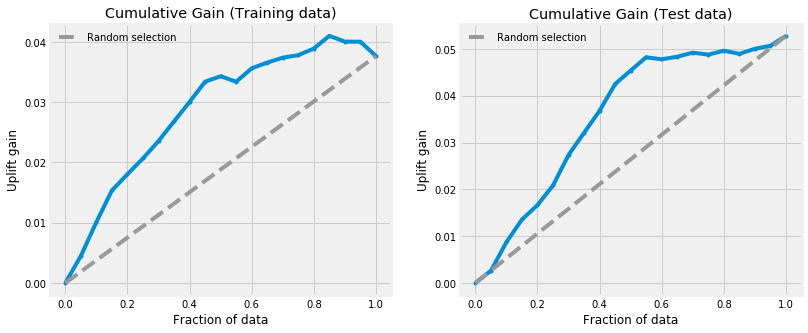

In [5]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up1.train_results_.plot(ax=ax);
ax.set_title("Cumulative Gain (Training data)")

ax = fig.add_subplot(122)
up1.test_results_.plot(ax=ax);
ax.set_title("Cumulative Gain (Test data)")

print("Cumulative Gain AUC: {:.5f}".format(up1.train_results_.Q_cgains))
print("Cumulative Gain AUC: {:.5f}".format(up1.test_results_.Q_cgains))

<br>
<br>

### Build response (risk) model

I follow the methodology and nomenclature of the analysis performed by [Ascarza (2018)](https://journals.sagepub.com/doi/full/10.1509/jmr.16.0163). As a result I use the terms response model and risk model interchangeably however they mean exactly the same thing in this context. In churn prediction parlance the response model is sometimes referred to as a risk model from its use to compute the probability of customer churn aka risk of churning. In this case the risk model is used to compute the propensity to visit the site thus the risk refers to the "risk" of visiting.

In [6]:
# Train on control group in calibration set, predict on treatment and control group in validation set
train_df = up1.df_train[up1.df_train.Treatment==0].copy()
test_df = up1.df_test.copy()

# Drop other outcomes
train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

# Set up train/test df
train_label = train_df.Outcome
test_label = test_df.Outcome
train_df = train_df.drop(columns='Outcome')
test_df = test_df.drop(columns='Outcome')

In [ ]:
state = 30
xgb = XGBClassifier(n_jobs=2, random_state=state)

param_grid = {
        'silent': [False],
        'max_depth': list(range(2,35)),
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.05, 0.07, 0,1, 0.3, 1],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.1, 0.3, 0.5, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_lambda': [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
        'n_estimators': list(range(50,501))
}


rs = RandomizedSearchCV(xgb, 
                        param_grid,
                        n_iter=1000,
                        scoring='neg_log_loss',
                        n_jobs=2,
                        iid=False, 
                        cv=5,
                        random_state=state,
                        verbose=1
                       )

rs.fit(train_df, train_label)    

best_score = rs.best_score_
best_params = rs.best_params_
best_params

In [7]:
best_params = {'subsample': 0.7,
 'silent': False,
 'reg_lambda': 3,
 'n_estimators': 260,
 'min_child_weight': 0.1,
 'max_depth': 2,
 'learning_rate': 0.03,
 'gamma': 0.8,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.6}

xgb = XGBClassifier(**best_params, n_jobs=2, random_state=state)
xgb.fit(train_df, train_label)
y_pred_risk = xgb.predict_proba(test_df)[:,1]

results_df = up1.df_test.copy()
results_df['risk'] = y_pred_risk
results_df['uplift'] = up1.transformed_y_test_pred
results_df['risk_decile'] = pd.qcut(y_pred_risk, 10)
results_df['uplift_decile'] = pd.qcut(up1.transformed_y_test_pred, 10)

del y_pred_risk

<br>
<br>

### Comparison of visit rates between risk and uplift model

In [8]:
def compute_treatment_effect(results, for_risk=True):
    if for_risk:
        targeting_strategy = 'risk_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treated_customers = results[results.Treatment==1]
    control_customers = results[results.Treatment==0]
    treated_visit_rates = ( \
                            treated_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            treated_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    control_visit_rates = ( \
                            control_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            control_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    te = pd.DataFrame(treated_visit_rates - control_visit_rates).reset_index()
    te[targeting_strategy] = te[targeting_strategy].astype(str)
    te.columns = [targeting_strategy, 'Treatment_Effect']
    return te


def compute_visit_rates(results, for_risk=True):   
    if for_risk:
        targeting_strategy = 'risk_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treated_customers = results[results.Treatment==1]
    control_customers = results[results.Treatment==0]
    treated_visit_rates = ( \
                            treated_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            treated_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    control_visit_rates = ( \
                            control_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            control_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    treated_visit_rates = pd.DataFrame(treated_visit_rates).reset_index()
    treated_visit_rates[targeting_strategy] = treated_visit_rates[targeting_strategy].astype(str)
    treated_visit_rates.columns = [targeting_strategy, 'visit_rate']
    control_visit_rates = pd.DataFrame(control_visit_rates).reset_index()
    control_visit_rates[targeting_strategy] = control_visit_rates[targeting_strategy].astype(str)
    control_visit_rates.columns = [targeting_strategy, 'visit_rate']                 
    return treated_visit_rates, control_visit_rates

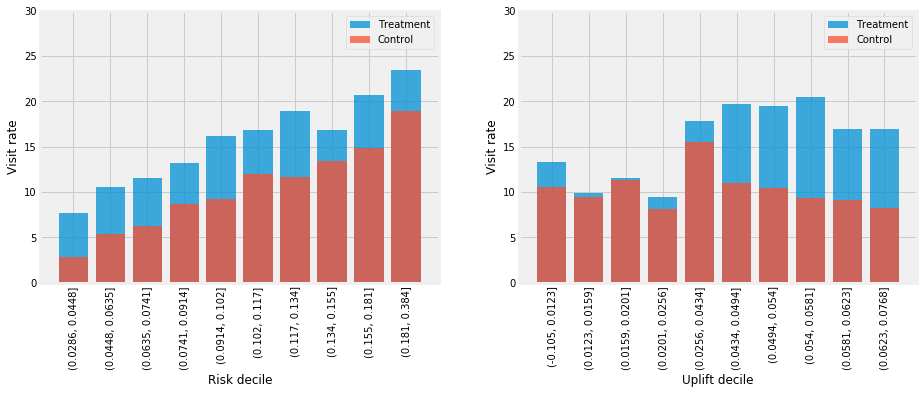

In [9]:
risk_treatment, risk_control = compute_visit_rates(results_df)
uplift_treatment, uplift_control = compute_visit_rates(results_df, for_risk=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(risk_treatment.risk_decile.values, risk_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax1.bar(risk_control.risk_decile.values, risk_control.visit_rate.values, label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Risk decile")
ax1.legend()
plt.xticks(rotation='vertical')
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_treatment.uplift_decile.values, uplift_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax2.bar(uplift_control.uplift_decile.values, uplift_control.visit_rate.values, label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile")
ax2.legend()
plt.xticks(rotation='vertical')
ax2.set_ylim(0,30);

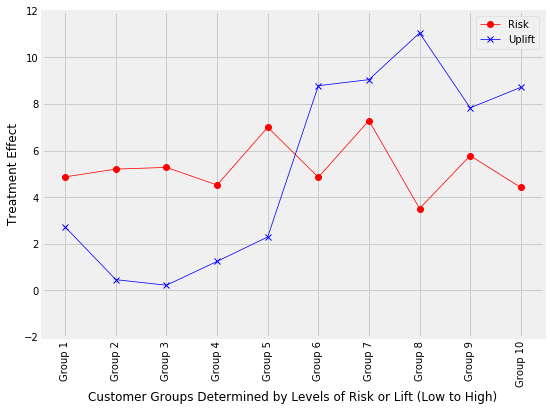

In [10]:
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
risk_te = compute_treatment_effect(results_df)
risk_te['group'] = group_labels
uplift_te = compute_treatment_effect(results_df, for_risk=False)
uplift_te['group'] = group_labels

plt.figure(figsize=(8,6))
plt.plot(risk_te.group.values, risk_te.Treatment_Effect.values, 'ro-', linewidth=0.75, label='Risk')
plt.plot(uplift_te.group.values, uplift_te.Treatment_Effect.values, 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer Groups Determined by Levels of Risk or Lift (Low to High)")
plt.legend()
plt.ylabel("Treatment Effect");

<br>
<br>

### impact of Direct Marketing campaign

- For risk model: Target customers with lowest probability of visiting first
- For uplift model: Target customers with highest uplift first

In [11]:
def compute_pooled_proportion(p1, n1, p2, n2):
    return ((p1*n1)+(p2*n2)) / (n1+n2)

def compute_se(p, n1, n2):
    return np.sqrt(p*(1-p)*((1/n1)+(1/n2)))

def compute_impact(results, for_risk=True):
    if for_risk:
        targeting_strategy = 'risk_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treated_customers = results[results.Treatment==1]
    control_customers = results[results.Treatment==0]
    treated_visit = ( \
                     treated_customers.groupby(targeting_strategy)['Outcome'].sum() \
                    ) 
    treated_total = ( \
                     treated_customers.groupby(targeting_strategy)['Outcome'].count() \
                    ) 
    control_visit = ( \
                     control_customers.groupby(targeting_strategy)['Outcome'].sum() \
                    )
    control_total = ( \
                     control_customers.groupby(targeting_strategy)['Outcome'].count() \
                    ) 
    treated_visit = pd.DataFrame(treated_visit).reset_index()
    treated_visit[targeting_strategy] = treated_visit[targeting_strategy].astype(str)
    treated_visit.columns = [targeting_strategy, 'visited']
    treated_visit['total'] = treated_total.values
    
    control_visit = pd.DataFrame(control_visit).reset_index()
    control_visit[targeting_strategy] = control_visit[targeting_strategy].astype(str)
    control_visit.columns = [targeting_strategy, 'visited']
    control_visit['total'] = control_total.values
    
    # Target high uplift, low risk first
    if not for_risk:
        treated_visit, control_visit = treated_visit.iloc[::-1], control_visit.iloc[::-1]
    
    # Target high uplift, high risk first
    #treated_visit, control_visit = treated_visit.iloc[::-1], control_visit.iloc[::-1]
        
    treated_visit['visit_cumsum'] = treated_visit.visited.cumsum()
    treated_visit['total_cumsum'] = treated_visit.total.cumsum()
    treated_visit['cumsum_visit_rate'] = treated_visit.visit_cumsum / treated_visit.total_cumsum
    control_visit['visit_cumsum'] = control_visit.visited.cumsum()
    control_visit['total_cumsum'] = control_visit.total.cumsum()
    control_visit['cumsum_visit_rate'] = control_visit.visit_cumsum / control_visit.total_cumsum
    
    impact_df = treated_visit[[targeting_strategy]].copy()
    impact_df['cumsum_treatment_effect'] = treated_visit.cumsum_visit_rate - control_visit.cumsum_visit_rate
    
    p1, p2 = treated_visit.cumsum_visit_rate, control_visit.cumsum_visit_rate
    n1, n2 = treated_visit.total_cumsum, control_visit.total_cumsum
    
    impact_df['pooled_cumsum_proportion'] = compute_pooled_proportion(p1, n1, p2, n2)
    impact_df['standard_error'] = compute_se(impact_df['pooled_cumsum_proportion'].values, n1, n2)

    return impact_df, treated_visit, control_visit

In [12]:
risk_impact_df, _, _ = compute_impact(results_df, for_risk=True)
uplift_impact_df, _, _ = compute_impact(results_df, for_risk=False)

group_labels = [str(group*10)+'%' for group in list(range(1,11))]
risk_impact_df['group'] = group_labels
uplift_impact_df['group'] = group_labels

Average Treatment Effect in test data

In [13]:
womens = results_df[results_df.Treatment==1].Outcome.mean()*100
control = results_df[results_df.Treatment==0].Outcome.mean()*100
ate_test = womens-control
print("Womens's visit rate uplift: {:.2f}%".format(ate_test))
del womens, control

Womens's visit rate uplift: 5.28%


This is the expected visit rate uplift of the email when randomly targeting customers

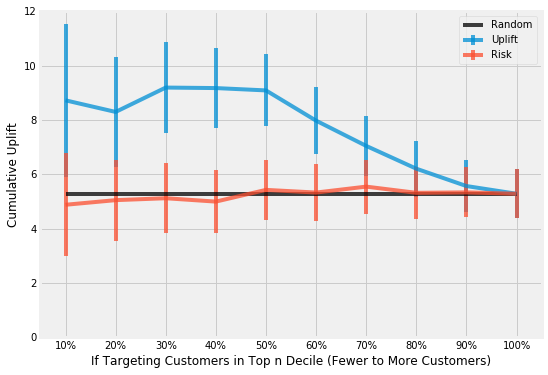

In [14]:
plt.figure(figsize=(8,6))
plt.errorbar(uplift_impact_df.group, uplift_impact_df.cumsum_treatment_effect*100, (uplift_impact_df.standard_error*100*1.96), label='Uplift', alpha=0.75)
plt.errorbar(risk_impact_df.group, risk_impact_df.cumsum_treatment_effect*100, (risk_impact_df.standard_error*100*1.96), label='Risk', alpha=0.75)
plt.ylim(0,12)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.ylabel("Cumulative Uplift")
plt.hlines(ate_test, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.legend();

<br>
<br>

### Customer characteristics by uplift

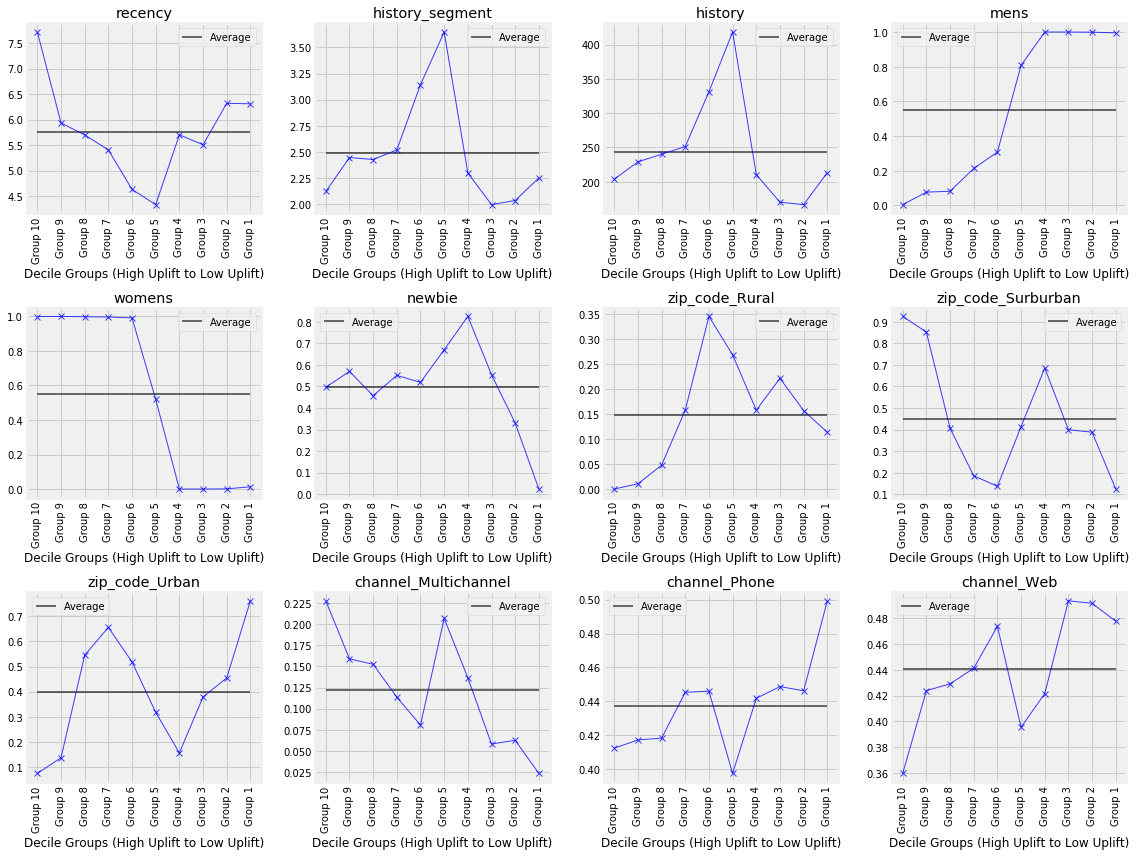

In [15]:
feat_names = list(results_df.drop(columns=['TransformedOutcome', 'Treatment', 'Outcome', 'risk', 'uplift', 'risk_decile']).columns)

avg_by_uplift_decile = results_df[feat_names].groupby('uplift_decile').mean().reset_index()
columns = []
feats = []
for col in avg_by_uplift_decile.columns:
    if col[1] == '':
        columns.append(col[0])
    else:
        feats.append(col[0])
        columns.append(col[0]+'_'+col[1])

avg_by_uplift_decile['uplift_decile'] = avg_by_uplift_decile['uplift_decile'].astype(str)
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
avg_by_uplift_decile['group'] = group_labels
avg_by_uplift_decile = avg_by_uplift_decile.iloc[::-1]


fig = plt.figure(figsize=(16,12))
for idx, col in enumerate(avg_by_uplift_decile.iloc[:,1:13]):
    ax = fig.add_subplot(3,4,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(col)
    ax.plot(avg_by_uplift_decile.group, avg_by_uplift_decile[col], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[col].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()

<br>
<br>

With error bars?

In [ ]:
feat_names = list(results_df.drop(columns=['TransformedOutcome', 'Treatment', 'risk', 'uplift', 'risk_decile']).columns)

avg_by_uplift_decile = results_df[feat_names].groupby('uplift_decile').agg(['mean', 'std']).reset_index()
columns = []
feats = []
for col in avg_by_uplift_decile.columns:
    if col[1] == '':
        columns.append(col[0])
    else:
        feats.append(col[0])
        columns.append(col[0]+'_'+col[1])
avg_by_uplift_decile.columns = columns
#feats = feats[::2]
del columns

avg_by_uplift_decile['uplift_decile'] = avg_by_uplift_decile['uplift_decile'].astype(str)
avg_by_uplift_decile = avg_by_uplift_decile.iloc[::-1]

for idx, col in enumerate(avg_by_uplift_decile.iloc[:,1:,]):
    if idx%2 == 0:  # feat means
        feat_name = col
    else:
        std_name = col  # feat stds
        avg = results_df[feats[idx]].mean()  # feat overall means

        plt.figure(figsize=(8,6))
        plt.errorbar(avg_by_uplift_decile.uplift_decile, avg_by_uplift_decile[feat_name], (avg_by_uplift_decile[std_name])/2, alpha=0.75)
        plt.hlines(avg, 0, 9, label='Average', alpha=0.75)
        plt.xticks(rotation='vertical')
        plt.ylabel(feats[idx])
        plt.xlabel('Uplift Decile Interval (High to Low)')
        plt.title('Average '+feats[idx]+' by uplift decile group')

<br>
<br>

### Build Uplift & Response models for Men's Visit Rate

In [16]:
mens_df = df[df.segment!='Womens E-Mail'].copy()
womens_df = df[df.segment!='Mens E-Mail'].copy()

# Label encode segment as treatment column
mens_df.segment.replace({'Mens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)

# Drop conversion and spend outcomes
mens_df.drop(columns=['conversion', 'spend'], inplace=True)
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

# Ordinal encode "history_segment"
hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

mens_df.history_segment.replace(hist_seg_map, inplace=True)
womens_df.history_segment.replace(hist_seg_map, inplace=True)

# OHE categorical variables
mens_df = pd.get_dummies(mens_df)
womens_df = pd.get_dummies(womens_df)

# Label treatment and outcome columns
mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)

state = 5

# Build Uplift model using pylift package
up2 = TransformedOutcome(mens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=mens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

In [ ]:
# RandomizedSearchCV.
up2.randomized_search(param_distributions={'max_depth': range(3,75),
                                           'min_samples_split': range(500,1800),
                                           'max_features':['auto', 'sqrt'],
                                           'n_estimators': range(3,12),
                                           'random_state': [state]
                                          },
                      n_iter=250,
                      cv=5,
                      n_jobs=6,
                      random_state=state
                     )

up2.rand_search_.best_params_

Cumulative Gain AUC: 0.01106
Cumulative Gain AUC: 0.00129


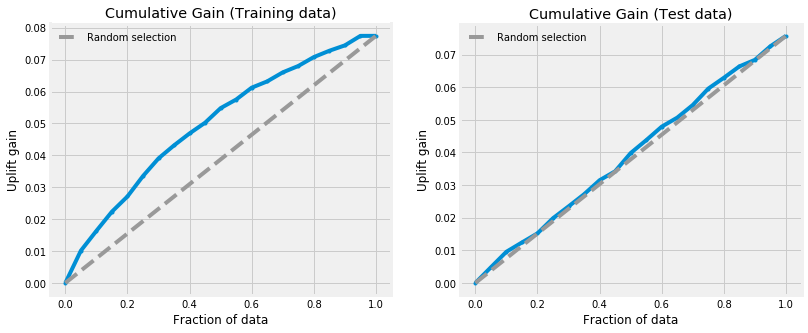

In [17]:
best_params = {'random_state': 5, # State 5
 'n_estimators': 50,
 'min_samples_split': 3000,
 'max_features': 'sqrt',
 'max_depth': 8}

up2.fit(**best_params)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up2.train_results_.plot(ax=ax);
ax.set_title("Cumulative Gain (Training data)")

ax = fig.add_subplot(122)
up2.test_results_.plot(ax=ax);
ax.set_title("Cumulative Gain (Test data)")

print("Cumulative Gain AUC: {:.5f}".format(up2.train_results_.Q_cgains))
print("Cumulative Gain AUC: {:.5f}".format(up2.test_results_.Q_cgains))

In [18]:
# Train on control group in calibration set, predict on treatment and control group in validation set
train_df = up2.df_train[up2.df_train.Treatment==0].copy()
test_df = up2.df_test.copy()

# Drop other outcomes
train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

# Set up train/test df
train_label = train_df.Outcome
test_label = test_df.Outcome
train_df = train_df.drop(columns='Outcome')
test_df = test_df.drop(columns='Outcome')

In [ ]:
xgb = XGBClassifier(n_jobs=2, random_state=state)

param_grid = {
        'silent': [False],
        'max_depth': list(range(2,35)),
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.05, 0.07, 0,1, 0.3, 1],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.1, 0.3, 0.5, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_lambda': [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
        'n_estimators': list(range(50,501))
}


rs = RandomizedSearchCV(xgb, 
                        param_grid,
                        n_iter=500,
                        scoring='neg_log_loss',
                        n_jobs=2,
                        iid=False, 
                        cv=5,
                        random_state=state,
                        verbose=1
                       )

rs.fit(train_df, train_label)    

best_score = rs.best_score_
best_params = rs.best_params_
best_params

In [19]:
best_params = {'subsample': 0.8,
 'silent': False,
 'reg_lambda': 0.03,
 'n_estimators': 148,
 'min_child_weight': 7.0,
 'max_depth': 2,
 'learning_rate': 0.05,
 'gamma': 0.6,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.8}

xgb = XGBClassifier(**best_params, n_jobs=2, random_state=state)
xgb.fit(train_df, train_label)
y_pred_risk = xgb.predict_proba(test_df)[:,1]

results_df = up2.df_test.copy()
results_df['risk'] = y_pred_risk
results_df['uplift'] = up2.transformed_y_test_pred
results_df['risk_decile'] = pd.qcut(y_pred_risk, 10)
results_df['uplift_decile'] = pd.qcut(up2.transformed_y_test_pred, 10)

del y_pred_risk

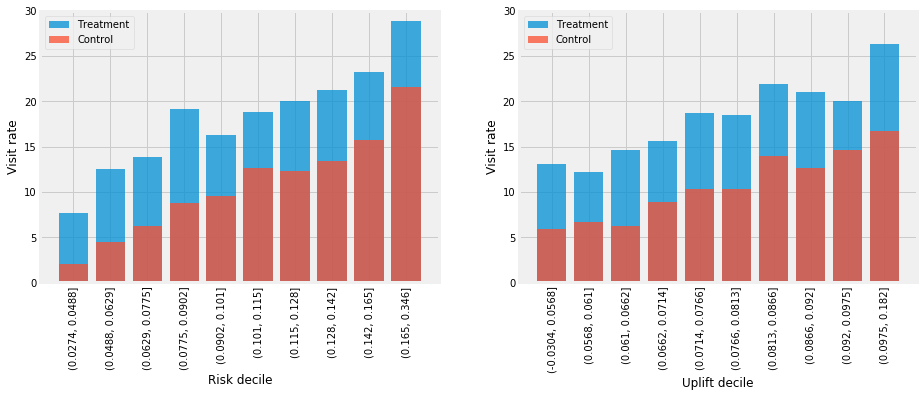

In [20]:
risk_treatment, risk_control = compute_visit_rates(results_df)
uplift_treatment, uplift_control = compute_visit_rates(results_df, for_risk=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(risk_treatment.risk_decile.values, risk_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax1.bar(risk_control.risk_decile.values, risk_control.visit_rate.values, label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Risk decile")
ax1.legend()
plt.xticks(rotation='vertical')
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_treatment.uplift_decile.values, uplift_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax2.bar(uplift_control.uplift_decile.values, uplift_control.visit_rate.values, label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile")
ax2.legend()
plt.xticks(rotation='vertical')
ax2.set_ylim(0,30);

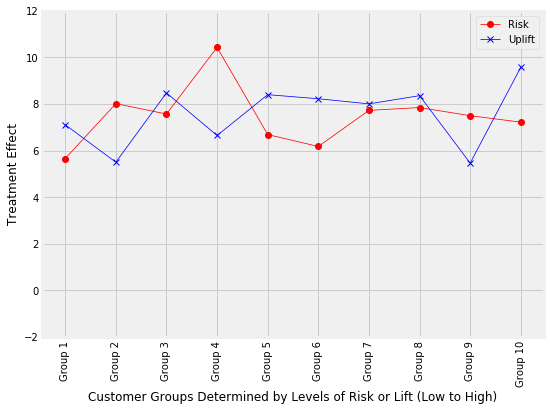

In [21]:
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
risk_te = compute_treatment_effect(results_df)
risk_te['group'] = group_labels
uplift_te = compute_treatment_effect(results_df, for_risk=False)
uplift_te['group'] = group_labels

plt.figure(figsize=(8,6))
plt.plot(risk_te.group.values, risk_te.Treatment_Effect.values, 'ro-', linewidth=0.75, label='Risk')
plt.plot(uplift_te.group.values, uplift_te.Treatment_Effect.values, 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer Groups Determined by Levels of Risk or Lift (Low to High)")
plt.legend()
plt.ylabel("Treatment Effect");

In [22]:
risk_impact_df, _, _ = compute_impact(results_df, for_risk=True)
uplift_impact_df, _, _ = compute_impact(results_df, for_risk=False)

group_labels = [str(group*10)+'%' for group in list(range(1,11))]
risk_impact_df['group'] = group_labels
uplift_impact_df['group'] = group_labels

Average Treatment Effect in test data

In [23]:
womens = results_df[results_df.Treatment==1].Outcome.mean()*100
control = results_df[results_df.Treatment==0].Outcome.mean()*100
ate_test = womens-control
print("Men's visit rate uplift: {:.2f}%".format(ate_test))
del womens, control

Men's visit rate uplift: 7.57%


This is the expected uplift of the treatment with random targeting

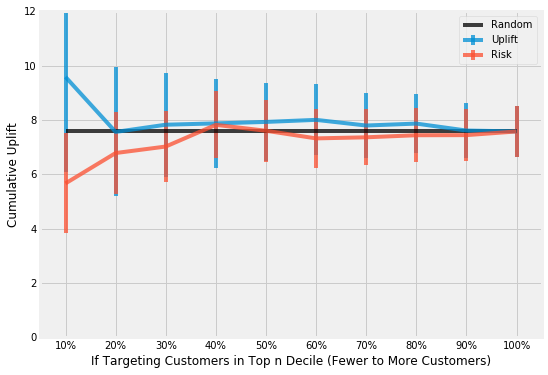

In [24]:
plt.figure(figsize=(8,6))
plt.errorbar(uplift_impact_df.group, uplift_impact_df.cumsum_treatment_effect*100, (uplift_impact_df.standard_error*100*1.96), label='Uplift', alpha=0.75)
plt.errorbar(risk_impact_df.group, risk_impact_df.cumsum_treatment_effect*100, (risk_impact_df.standard_error*100*1.96), label='Risk', alpha=0.75)
plt.ylim(0,12)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.ylabel("Cumulative Uplift")
plt.hlines(ate_test, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.legend();

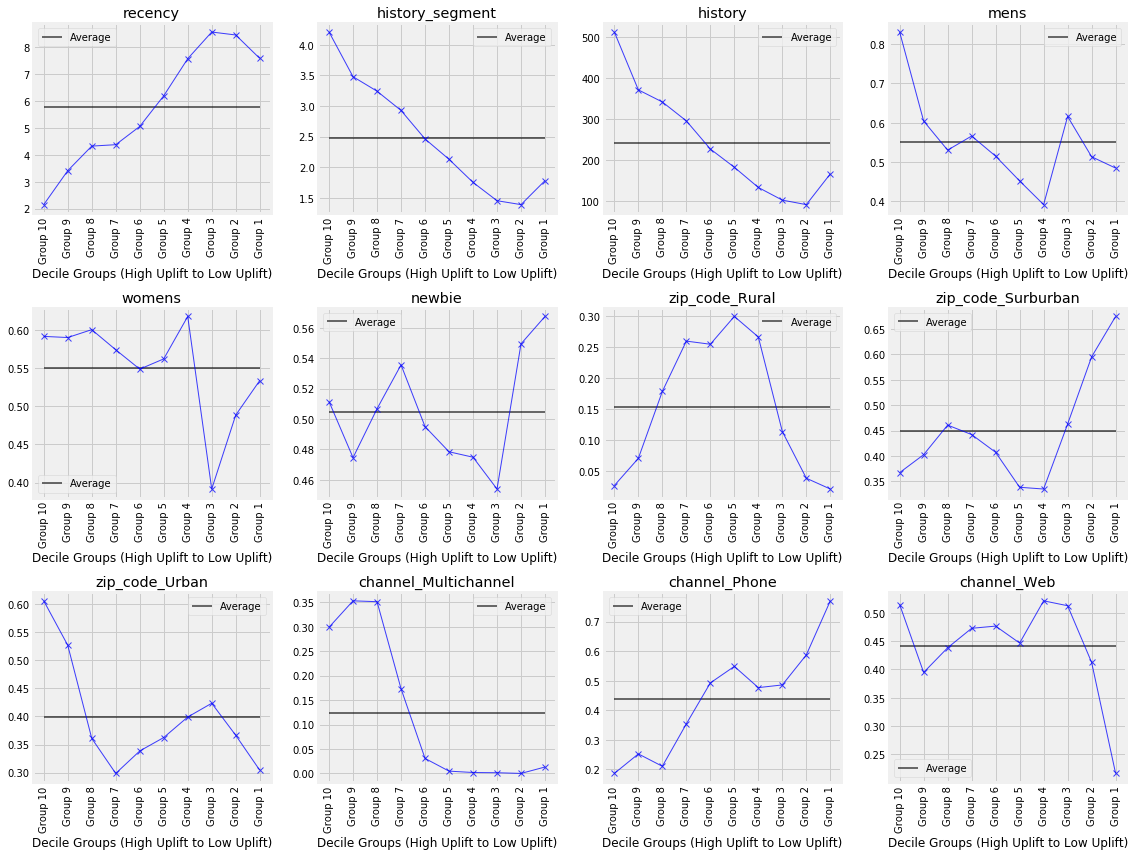

In [25]:
feat_names = list(results_df.drop(columns=['TransformedOutcome', 'Treatment', 'Outcome', 'risk', 'uplift', 'risk_decile']).columns)

avg_by_uplift_decile = results_df[feat_names].groupby('uplift_decile').mean().reset_index()
columns = []
feats = []
for col in avg_by_uplift_decile.columns:
    if col[1] == '':
        columns.append(col[0])
    else:
        feats.append(col[0])
        columns.append(col[0]+'_'+col[1])

avg_by_uplift_decile['uplift_decile'] = avg_by_uplift_decile['uplift_decile'].astype(str)
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
avg_by_uplift_decile['group'] = group_labels
avg_by_uplift_decile = avg_by_uplift_decile.iloc[::-1]


fig = plt.figure(figsize=(16,12))
for idx, col in enumerate(avg_by_uplift_decile.iloc[:,1:13]):
    ax = fig.add_subplot(3,4,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(col)
    ax.plot(avg_by_uplift_decile.group, avg_by_uplift_decile[col], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[col].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()